In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import rcParams

# =============================================================================
#                      Hyperparameters & Settings
# =============================================================================
NN       = 10      # Number of neurons per hidden layer
NL       = 5       # Total number of hidden layers
N_points = 200     # Number of collocation/integration points (for training)
N_test   = 10      # Number of test points (for validation/testing)
N_epoch  = 5000    # Number of training epochs

# =============================================================================
#                 PDE Source Function & Exact Solution
# =============================================================================
def f_source(x):
    """
    Forcing term f(x) for the PDE (used in loss computation):
      -Δu = f  with f(x) = 4·sin(2x)
    """
    return 4 * tf.sin(2 * x)

def uexact(x):
    """
    Known analytical solution for comparison:
      u_exact(x) = sin(2x)
    """
    return tf.sin(2 * x)

# =============================================================================
#                   Neural Network Architecture
# =============================================================================
# Input layer: scalar spatial coordinate x
X = tf.keras.layers.Input(shape=(1,))

# First hidden layer: NN neurons with tanh activation
L = tf.keras.layers.Dense(units=NN, activation='tanh')(X)

# Additional hidden layers: total of NL layers
for _ in range(NL - 1):
    L = tf.keras.layers.Dense(units=NN, activation='tanh')(L)

# Last dense layer: outputs scalar u(x)
L_last = tf.keras.layers.Dense(units=1, activation='tanh')(L)

# =============================================================================
#                 Custom Cutoff Layer Definition
# =============================================================================
class cutoff(tf.keras.layers.Layer):
    """
    Applies a spatial cutoff function cut(x) = x*(x - π) to u(x):
      - Ensures u(0) = 0 and u(π) = 0 by zeroing at boundaries.
    """
    def __init__(self, **kwargs):
        super(cutoff, self).__init__()

    def call(self, inputs):
        x, u = inputs  # x: input coordinate, u: NN output
        cut = x * (x - np.pi)  # cut(x) = x*(x-π)
        # Element-wise multiply: preserves shape [batch_size, 1]
        return tf.einsum("bi,bi->bi", cut, u)

# Apply the cutoff layer to enforce boundary conditions
U_out = cutoff()([X, L_last])

# =============================================================================
#                       Model Assembly & Summary
# =============================================================================
U_model = tf.keras.Model(inputs=X, outputs=U_out, name='U_model')
U_model.summary()




Model: "U_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │         20 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        110 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        110 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │        110 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │        110 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         11 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cutoff_1 (cutoff)   │ (None, 1)         │          0 │ input_layer_2[0]… │
│                     │                   │            │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 471 (1.84 KB)

 Trainable params: 471 (1.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# =============================================================================
#                  Custom Loss Layer for PDE Solver
# =============================================================================
class loss(tf.keras.layers.Layer):
    """
    Computes four metrics for the PDE -Δu = f on the interval [0, π]:
      1) loss_out          – squared L²‐norm of the variational residual over N_points
      2) relative_loss     – loss_out normalized by the exact solution’s H¹₀‐seminorm
      3) val_rel_loss      – validation residual (with finer sampling) normalized
      4) error_H01_rel     – relative H¹₀‐seminorm error between NN and exact derivative
    """
    def __init__(self, U_model, N_points, f_source, N_test, uexact, **kwargs):
        super(loss, self).__init__()
        # Neural network approximating u(x)
        self.U_model  = U_model
        # Number of random collocation points for training residual
        self.N_points = N_points
        # Forcing term f(x) in the PDE
        self.f_source = f_source
        # Number of basis/test functions
        self.N_test   = N_test
        # Exact (analytical) solution for boundary and error evaluation
        self.uexact   = uexact

    def call(self, inputs):
        # ----------------------------------------------------
        # 1) Sample random collocation points + include endpoints
        # ----------------------------------------------------
        random_pts = tf.random.uniform(
            shape=(self.N_points,), minval=0.0, maxval=np.pi, dtype=tf.float64
        )
        extremes     = tf.concat([[0.0], random_pts, [np.pi]], axis=0)
        sorted_pts   = tf.sort(extremes)
        # Midpoints and interval lengths for quadrature
        S            = (sorted_pts[:-1] + sorted_pts[1:]) / 2
        interval_sz  = sorted_pts[1:] - sorted_pts[:-1]

        # ----------------------------------------------------
        # 2) Compute u_x = d(u_model)/dx at those midpoints
        # ----------------------------------------------------
        with tf.GradientTape(persistent=True) as gt:
            gt.watch(S)
            u_eval = self.U_model(S)
            u_x    = gt.gradient(u_eval, S)
        del gt

        # ----------------------------------------------------
        # 3) Assemble variational form integrals for training loss
        # ----------------------------------------------------
        F  = self.f_source(S)  # f(x) at sample points

        # Basis functions G_i(x) = (1/i)*(√2/π)*sin(i·S)
        G = tf.experimental.numpy.asarray([
            (1.0/i)*(np.sqrt(2)/np.pi)*tf.math.sin(i * S)
            for i in range(1, self.N_test + 1)
        ], dtype='float64')

        # Gradients H_i(x) = (√2/π)*cos(i·S)
        H = tf.experimental.numpy.asarray([
            (np.sqrt(2)/np.pi)*tf.cos(i * S)
            for i in range(1, self.N_test + 1)
        ], dtype='float64')

        # ∫ F·G    and   ∫ u_x·H
        Integral_source = tf.einsum('i,i,ki->k', F, interval_sz, G)
        Integral_Unn    = tf.einsum('i,i,ki->k', u_x, interval_sz, H)

        # Squared residual sum
        loss_out = tf.reduce_sum((-Integral_source + Integral_Unn) ** 2)

        # ----------------------------------------------------
        # 4) Validation on finer grid
        # ----------------------------------------------------
        Sval = tf.experimental.numpy.linspace(
            0.0, np.pi, num=self.N_points * 10, dtype='float64'
        )
        with tf.GradientTape(persistent=True) as gt:
            gt.watch(Sval)
            u_eval_val = self.U_model(Sval)
            u_x_val    = gt.gradient(u_eval_val, Sval)
            u_ex       = self.uexact(Sval)
            u_ex_x     = gt.gradient(u_ex, Sval)
        del gt

        Fval = self.f_source(Sval)
        Gval = tf.experimental.numpy.asarray([
            (1.0/i)*(np.sqrt(2)/np.pi)*tf.math.sin(i * Sval)
            for i in range(1, self.N_test + 1)
        ], dtype='float64')
        Hval = tf.experimental.numpy.asarray([
            (np.sqrt(2)/np.pi)*tf.cos(i * Sval)
            for i in range(1, self.N_test + 1)
        ], dtype='float64')

        # Weighted by Δx = π/(N_points*10)
        dx_val = np.pi / (self.N_points * 10)
        Integral_source_val = dx_val * tf.einsum('i,ki->k', Fval, Gval)
        Integral_Unn_val    = dx_val * tf.einsum('i,ki->k', u_x_val, Hval)

        val_out = tf.reduce_sum((-Integral_source_val + Integral_Unn_val) ** 2)

        # ----------------------------------------------------
        # 5) Relative H¹₀‐seminorm error
        # ----------------------------------------------------
        error_H01 = tf.reduce_mean((u_ex_x - u_x_val) ** 2)
        norm_exact = tf.reduce_mean(u_ex_x ** 2)

        # ----------------------------------------------------
        # 6) Return stacked metrics:
        #    [training_loss,
        #     training_loss / norm_exact,
        #     val_out / norm_exact,
        #     error_H01 / norm_exact]
        # ----------------------------------------------------
        return tf.stack([
            loss_out,
            loss_out / norm_exact,
            val_out   / norm_exact,
            error_H01 / norm_exact
        ])

  


In [ ]:
# =============================================================================
#                     Loss Model Construction Function
# =============================================================================
def loss_model(U_model, N_points, f_source, N_test, uexact):
    """
    Wraps the custom loss layer in a Keras Model so that TensorFlow
    can compute the PDE loss during training.
    
    Parameters:
      U_model   – neural network approximating u(x)
      N_points  – number of collocation points for integrals
      f_source  – forcing term f(x) in -Δu = f
      N_test    – number of basis/test functions
      uexact    – analytical solution for validation/error norms
    Returns:
      A Keras Model whose output is the stacked loss vector.
    """
    # Dummy input (required by Keras API, not used inside loss)
    Xl = tf.keras.layers.Input(shape=(1,))

    # Compute custom loss vector [train_loss, rel_loss, val_loss, error_value]
    loss_layer = loss(U_model, N_points, f_source, N_test, uexact)(Xl)

    # Build and return the model mapping dummy input → loss vector
    return tf.keras.Model(inputs=Xl, outputs=loss_layer)


# =============================================================================
#                  Metric Extraction Helper Functions
# =============================================================================
def loss_value(x, y):
    """Primary training loss (first element of loss vector)."""
    return y[0]

def loss_rel(x, y):
    """Relative training loss (second element)."""
    return y[1]

def val_value(x, y):
    """Validation loss (third element)."""
    return y[2]

def error_value(x, y):
    """Relative H¹₀‐error metric (fourth element)."""
    return y[3]


# =============================================================================
#               Assemble, Compile, and Train the Model
# =============================================================================
# 1) Create the loss‐model that produces our custom loss metrics
model_all = loss_model(U_model, N_points, f_source, N_test, uexact)

# 2) Choose optimizer: Adam with learning rate 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=10**-3)

# 3) Compile:
#    - loss_value: primary scalar loss for gradient descent
#    - metrics: additional diagnostics during training
model_all.compile(
    optimizer=optimizer,
    loss=loss_value,
    metrics=[loss_rel, val_value, error_value]
)

# 4) Train with dummy inputs to invoke the custom loss computation
#    (x and y arrays of shape [1], values are placeholders)
history = model_all.fit(
    x=np.array([1.]), 
    y=np.array([1.]), 
    epochs=N_epoch
)



Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - error_value: 0.8437 - loss: 1.6871 - loss_rel: 0.8431 - val_value: 0.8421
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.7703 - loss: 1.5405 - loss_rel: 0.7699 - val_value: 0.7689
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.7145 - loss: 1.4287 - loss_rel: 0.7140 - val_value: 0.7131
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.6712 - loss: 1.3424 - loss_rel: 0.6709 - val_value: 0.6699
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.6352 - loss: 1.2699 - loss_rel: 0.6346 - val_value: 0.6339
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.6031 - loss: 1.2062 - loss_rel: 0.6028 - val_value: 0.6019
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.5734 - loss: 1.1478 - loss_rel: 0.5736 - val_value: 0.5722
Epoch 8/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.5446 - loss: 1.0889 - loss_rel: 0.5442 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0057 - loss: 0.0097 - loss_rel: 0.0049 - val_value: 0.0057
Epoch 45/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0065 - loss: 0.0121 - loss_rel: 0.0061 - val_value: 0.0065
Epoch 46/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0073 - loss: 0.0140 - loss_rel: 0.0070 - val_value: 0.0073
Epoch 47/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0081 - loss: 0.0159 - loss_rel: 0.0079 - val_value: 0.0081
Epoch 48/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0086 - loss: 0.0166 - loss_rel: 0.0083 - val_value: 0.0087
Epoch 49/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0090 - loss: 0.0174 - loss_rel: 0.0087 - val_value: 0.0091
Epoch 50/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0093 - loss: 0.0183 - loss_rel: 0.0092 - val_value: 0.0093
Epoch 51/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0095 - loss: 0.0209 - loss_rel: 0.0105 - val_valu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - error_value: 0.0036 - loss: 0.0069 - loss_rel: 0.0034 - val_value: 0.0035
Epoch 95/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0036 - loss: 0.0066 - loss_rel: 0.0033 - val_value: 0.0035
Epoch 96/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0036 - loss: 0.0066 - loss_rel: 0.0033 - val_value: 0.0035
Epoch 97/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0035 - loss: 0.0064 - loss_rel: 0.0032 - val_value: 0.0035
Epoch 98/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0035 - loss: 0.0065 - loss_rel: 0.0032 - val_value: 0.0035
Epoch 99/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0035 - loss: 0.0063 - loss_rel: 0.0032 - val_value: 0.0034
Epoch 100/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0035 - loss: 0.0065 - loss_rel: 0.0032 - val_value: 0.0034
Epoch 101/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0035 - loss: 0.0064 - loss_rel: 0.0032 - val_va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0031 - loss: 0.0057 - loss_rel: 0.0028 - val_value: 0.0031
Epoch 145/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0031 - loss: 0.0057 - loss_rel: 0.0029 - val_value: 0.0031
Epoch 146/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0031 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0031
Epoch 147/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0031 - loss: 0.0057 - loss_rel: 0.0029 - val_value: 0.0031
Epoch 148/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0031 - loss: 0.0060 - loss_rel: 0.0030 - val_value: 0.0031
Epoch 149/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0031 - loss: 0.0058 - loss_rel: 0.0029 - val_value: 0.0030
Epoch 150/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0031 - loss: 0.0055 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 151/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0031 - loss: 0.0053 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 195/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 196/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - error_value: 0.0030 - loss: 0.0059 - loss_rel: 0.0030 - val_value: 0.0030
Epoch 197/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0030 - loss: 0.0057 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 198/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 199/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0030 - loss: 0.0057 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 200/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0030
Epoch 201/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0057 - loss_rel: 0.0029 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 245/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 246/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0030 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0029
Epoch 247/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 248/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 249/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 250/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 251/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 295/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0057 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 296/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0051 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 297/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 298/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0057 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 299/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0058 - loss_rel: 0.0029 - val_value: 0.0029
Epoch 300/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 301/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 345/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 346/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0057 - loss_rel: 0.0029 - val_value: 0.0029
Epoch 347/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0059 - loss_rel: 0.0029 - val_value: 0.0029
Epoch 348/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 349/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 350/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 351/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0027 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0058 - loss_rel: 0.0029 - val_value: 0.0029
Epoch 395/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 396/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 397/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 398/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 399/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 400/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0051 - loss_rel: 0.0025 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 445/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 446/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 447/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 448/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 449/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 450/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0055 - loss_rel: 0.0028 - val_value: 0.0029
Epoch 451/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0030 - loss: 0.0053 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 495/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 496/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0029 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0029
Epoch 497/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 498/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0029 - loss: 0.0055 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 499/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0029 - loss: 0.0057 - loss_rel: 0.0029 - val_value: 0.0029
Epoch 500/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0029 - loss: 0.0059 - loss_rel: 0.0030 - val_value: 0.0029
Epoch 501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0029 - loss: 0.0064 - loss_rel: 0.0032 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 545/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 546/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 547/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0029
Epoch 548/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 549/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0029
Epoch 550/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 0.0029 - loss: 0.0047 - loss_rel: 0.0023 - val_value: 0.0029
Epoch 551/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 595/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0029 - loss: 0.0051 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 596/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 597/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 598/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0029 - loss: 0.0055 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 599/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 600/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 601/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0029 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0028
Epoch 645/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0029 - loss: 0.0055 - loss_rel: 0.0028 - val_value: 0.0028
Epoch 646/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0029 - loss: 0.0051 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 647/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 648/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 649/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0029 - loss: 0.0069 - loss_rel: 0.0034 - val_value: 0.0028
Epoch 650/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 651/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0029 - loss: 0.0051 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0029 - loss: 0.0056 - loss_rel: 0.0028 - val_value: 0.0028
Epoch 695/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0029 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 696/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0029 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 697/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0029 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 698/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0028 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 699/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 700/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0028 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 701/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 745/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 746/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 747/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0051 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 748/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0053 - loss_rel: 0.0027 - val_value: 0.0028
Epoch 749/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0028
Epoch 750/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0028
Epoch 751/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0049 - loss_rel: 0.0025 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0028 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 795/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 796/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 797/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0028 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 798/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0051 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 799/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 800/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0028 - loss: 0.0047 - loss_rel: 0.0024 - val_value: 0.0027
Epoch 801/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0053 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 845/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0028 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 846/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0028 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 847/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 848/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 849/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 850/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0028 - loss: 0.0051 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 851/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0028 - loss: 0.0051 - loss_rel: 0.0026 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0028 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 895/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0027
Epoch 896/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 897/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0028 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 898/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 899/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 900/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 901/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0027 - loss: 0.0048 - loss_rel: 0.0024 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0027 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0027
Epoch 945/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 946/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0053 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 947/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 948/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0052 - loss_rel: 0.0026 - val_value: 0.0027
Epoch 949/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0027 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0027
Epoch 950/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0027
Epoch 951/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 995/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 996/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0049 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 997/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 998/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0027 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 999/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1000/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0027 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1001/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1045/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1046/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0027 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1047/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0027 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1048/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0027 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1049/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0027 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1050/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0027 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1051/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - error_value: 0.0027 - loss: 0.0048 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0047 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1095/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0026 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1096/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1097/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0049 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1098/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1099/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0050 - loss_rel: 0.0025 - val_value: 0.0026
Epoch 1100/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0026
Epoch 1101/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - error_value: 0.0026 - loss: 0.0050 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0026 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0025
Epoch 1145/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1146/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1147/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0026 - loss: 0.0047 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1148/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0025
Epoch 1149/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1150/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0026 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1151/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0026 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1195/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0026 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1196/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0026 - loss: 0.0049 - loss_rel: 0.0025 - val_value: 0.0025
Epoch 1197/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1198/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0026 - loss: 0.0047 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1199/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0026 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1200/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0026 - loss: 0.0045 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1201/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0026 - loss: 0.0043 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0025 - loss: 0.0047 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1245/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0025
Epoch 1246/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0025 - loss: 0.0047 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1247/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0025 - loss: 0.0047 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1248/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0025 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1249/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0025 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0025
Epoch 1250/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0025 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1251/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0025 - loss: 0.0047 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0025 - loss: 0.0045 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1295/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0054 - loss_rel: 0.0027 - val_value: 0.0025
Epoch 1296/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0025
Epoch 1297/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0025 - loss: 0.0045 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1298/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0025 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0025
Epoch 1299/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0025
Epoch 1300/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0025 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0025
Epoch 1301/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0043 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0051 - loss_rel: 0.0025 - val_value: 0.0024
Epoch 1345/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0048 - loss_rel: 0.0024 - val_value: 0.0024
Epoch 1346/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1347/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0047 - loss_rel: 0.0023 - val_value: 0.0024
Epoch 1348/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0025 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0024
Epoch 1349/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0025 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1350/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0025 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0024
Epoch 1351/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0025 - loss: 0.0045 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1395/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0024 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0024
Epoch 1396/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 0.0024 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0024
Epoch 1397/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0024 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1398/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0024 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1399/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0023 - val_value: 0.0024
Epoch 1400/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0024 - loss: 0.0046 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0024 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0024
Epoch 1445/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0024 - loss: 0.0047 - loss_rel: 0.0023 - val_value: 0.0024
Epoch 1446/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0024 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0024
Epoch 1447/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0024 - loss: 0.0043 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1448/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0024 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1449/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0024 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0024
Epoch 1450/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0024 - loss: 0.0043 - loss_rel: 0.0022 - val_value: 0.0024
Epoch 1451/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1495/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0024 - loss: 0.0043 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1496/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0024 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0023
Epoch 1497/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - error_value: 0.0024 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1498/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0024 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1499/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0024 - loss: 0.0043 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1500/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0024 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0024 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1545/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0024 - loss: 0.0046 - loss_rel: 0.0023 - val_value: 0.0023
Epoch 1546/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0023 - val_value: 0.0023
Epoch 1547/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - error_value: 0.0024 - loss: 0.0039 - loss_rel: 0.0019 - val_value: 0.0023
Epoch 1548/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0024 - loss: 0.0041 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1549/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0024 - loss: 0.0045 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1550/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0024 - loss: 0.0043 - loss_rel: 0.0022 - val_value: 0.0023
Epoch 1551/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 0.0023 - loss: 0.0044 - loss_rel: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0023 - loss: 0.0043 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1595/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0023 - loss: 0.0041 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1596/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1597/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - error_value: 0.0023 - loss: 0.0043 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1598/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0023 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0023
Epoch 1599/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1600/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0023
Epoch 1601/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 0.0023 - loss: 0.0043 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1645/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0023 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1646/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1647/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1648/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0023 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1649/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0023 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0022
Epoch 1650/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0023 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1651/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0023 - loss: 0.0043 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0023 - loss: 0.0041 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1695/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0023 - loss: 0.0043 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1696/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0023 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1697/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0023 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1698/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0023 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1699/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0023 - loss: 0.0043 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1700/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0023 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1701/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0023 - loss: 0.0041 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0022 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1745/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0022 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0022
Epoch 1746/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0022 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1747/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0022 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1748/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0022 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0022
Epoch 1749/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0022 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0022
Epoch 1750/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0022 - loss: 0.0039 - loss_rel: 0.0019 - val_value: 0.0022
Epoch 1751/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0022 - loss: 0.0040 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0022 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1795/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0022 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1796/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0022 - loss: 0.0041 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1797/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0022 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1798/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0022 - loss: 0.0041 - loss_rel: 0.0021 - val_value: 0.0021
Epoch 1799/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0022 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0021
Epoch 1800/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 0.0022 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1801/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 0.0022 - loss: 0.0042 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0022 - loss: 0.0039 - loss_rel: 0.0019 - val_value: 0.0021
Epoch 1845/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0022 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1846/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0022 - loss: 0.0041 - loss_rel: 0.0021 - val_value: 0.0021
Epoch 1847/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0022 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1848/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0022 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0021
Epoch 1849/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0022 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0021
Epoch 1850/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0022 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0021
Epoch 1851/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0022 - loss: 0.0038 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0021 - loss: 0.0044 - loss_rel: 0.0022 - val_value: 0.0021
Epoch 1895/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0021 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1896/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0021 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1897/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0021
Epoch 1898/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0043 - loss_rel: 0.0021 - val_value: 0.0021
Epoch 1899/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0039 - loss_rel: 0.0020 - val_value: 0.0021
Epoch 1900/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0018 - val_value: 0.0021
Epoch 1901/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0021 - loss: 0.0038 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0021 - loss: 0.0039 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1945/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1946/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0021 - loss: 0.0043 - loss_rel: 0.0022 - val_value: 0.0020
Epoch 1947/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1948/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0021 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1949/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0021 - loss: 0.0034 - loss_rel: 0.0017 - val_value: 0.0020
Epoch 1950/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1951/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0021 - loss: 0.0038 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1995/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0021 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1996/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1997/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 1998/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0021 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0020
Epoch 1999/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0042 - loss_rel: 0.0021 - val_value: 0.0020
Epoch 2000/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0020
Epoch 2001/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0021 - loss: 0.0036 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0020 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0019
Epoch 2045/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - error_value: 0.0020 - loss: 0.0037 - loss_rel: 0.0018 - val_value: 0.0019
Epoch 2046/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0020 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0019
Epoch 2047/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 0.0020 - loss: 0.0038 - loss_rel: 0.0019 - val_value: 0.0019
Epoch 2048/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0020 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0019
Epoch 2049/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0020 - loss: 0.0039 - loss_rel: 0.0019 - val_value: 0.0019
Epoch 2050/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0020 - loss: 0.0037 - loss_rel: 0.0019 - val_value: 0.0019
Epoch 2051/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0020 - loss: 0.0034 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0020 - loss: 0.0034 - loss_rel: 0.0017 - val_value: 0.0019
Epoch 2095/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0020 - loss: 0.0035 - loss_rel: 0.0017 - val_value: 0.0019
Epoch 2096/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0020 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0019
Epoch 2097/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0020 - loss: 0.0037 - loss_rel: 0.0018 - val_value: 0.0019
Epoch 2098/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0020 - loss: 0.0040 - loss_rel: 0.0020 - val_value: 0.0019
Epoch 2099/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0020 - loss: 0.0034 - loss_rel: 0.0017 - val_value: 0.0019
Epoch 2100/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0020 - loss: 0.0035 - loss_rel: 0.0017 - val_value: 0.0019
Epoch 2101/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0020 - loss: 0.0033 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0019 - loss: 0.0035 - loss_rel: 0.0018 - val_value: 0.0018
Epoch 2145/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0016 - val_value: 0.0018
Epoch 2146/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0017 - val_value: 0.0018
Epoch 2147/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0019 - loss: 0.0035 - loss_rel: 0.0018 - val_value: 0.0018
Epoch 2148/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0019 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0018
Epoch 2149/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0019 - loss: 0.0031 - loss_rel: 0.0016 - val_value: 0.0018
Epoch 2150/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0019 - loss: 0.0035 - loss_rel: 0.0017 - val_value: 0.0018
Epoch 2151/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0019 - loss: 0.0034 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0016 - val_value: 0.0018
Epoch 2195/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0019 - loss: 0.0036 - loss_rel: 0.0018 - val_value: 0.0018
Epoch 2196/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0016 - val_value: 0.0018
Epoch 2197/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0019 - loss: 0.0034 - loss_rel: 0.0017 - val_value: 0.0018
Epoch 2198/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0017 - val_value: 0.0018
Epoch 2199/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0017 - val_value: 0.0018
Epoch 2200/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0016 - val_value: 0.0018
Epoch 2201/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0019 - loss: 0.0033 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2245/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0018 - loss: 0.0034 - loss_rel: 0.0017 - val_value: 0.0017
Epoch 2246/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0018 - loss: 0.0033 - loss_rel: 0.0017 - val_value: 0.0017
Epoch 2247/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2248/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0018 - loss: 0.0030 - loss_rel: 0.0015 - val_value: 0.0017
Epoch 2249/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2250/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0018 - loss: 0.0033 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2251/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2295/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0018 - loss: 0.0031 - loss_rel: 0.0015 - val_value: 0.0017
Epoch 2296/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0018 - loss: 0.0030 - loss_rel: 0.0015 - val_value: 0.0017
Epoch 2297/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2298/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2299/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0017 - loss: 0.0031 - loss_rel: 0.0015 - val_value: 0.0017
Epoch 2300/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0017 - loss: 0.0031 - loss_rel: 0.0016 - val_value: 0.0017
Epoch 2301/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0018 - loss: 0.0032 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0017 - loss: 0.0031 - loss_rel: 0.0016 - val_value: 0.0016
Epoch 2345/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0017 - loss: 0.0028 - loss_rel: 0.0014 - val_value: 0.0016
Epoch 2346/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0017 - loss: 0.0028 - loss_rel: 0.0014 - val_value: 0.0016
Epoch 2347/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0017 - loss: 0.0029 - loss_rel: 0.0015 - val_value: 0.0016
Epoch 2348/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0017 - loss: 0.0030 - loss_rel: 0.0015 - val_value: 0.0016
Epoch 2349/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0017 - loss: 0.0030 - loss_rel: 0.0015 - val_value: 0.0016
Epoch 2350/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0017 - loss: 0.0031 - loss_rel: 0.0015 - val_value: 0.0016
Epoch 2351/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 0.0017 - loss: 0.0031 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 0.0016 - loss: 0.0029 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2395/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0016 - loss: 0.0027 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2396/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0016 - loss: 0.0028 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2397/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - error_value: 0.0016 - loss: 0.0029 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2398/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 0.0016 - loss: 0.0027 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2399/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 0.0016 - loss: 0.0028 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2400/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0016 - loss: 0.0028 - loss_rel: 0.0014 - val_value: 0.0015
Epoch 2401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0016 - loss: 0.0029 - loss_rel: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - error_value: 0.0015 - loss: 0.0026 - loss_rel: 0.0013 - val_value: 0.0014
Epoch 2445/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0015 - loss: 0.0026 - loss_rel: 0.0013 - val_value: 0.0014
Epoch 2446/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0015 - loss: 0.0025 - loss_rel: 0.0013 - val_value: 0.0014
Epoch 2447/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0015 - loss: 0.0028 - loss_rel: 0.0014 - val_value: 0.0014
Epoch 2448/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0015 - loss: 0.0026 - loss_rel: 0.0013 - val_value: 0.0014
Epoch 2449/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0015 - loss: 0.0027 - loss_rel: 0.0013 - val_value: 0.0014
Epoch 2450/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0015 - loss: 0.0026 - loss_rel: 0.0013 - val_value: 0.0014
Epoch 2451/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0015 - loss: 0.0027 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0014 - loss: 0.0024 - loss_rel: 0.0012 - val_value: 0.0013
Epoch 2495/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0014 - loss: 0.0024 - loss_rel: 0.0012 - val_value: 0.0013
Epoch 2496/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0014 - loss: 0.0025 - loss_rel: 0.0012 - val_value: 0.0013
Epoch 2497/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0014 - loss: 0.0026 - loss_rel: 0.0013 - val_value: 0.0013
Epoch 2498/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0014 - loss: 0.0024 - loss_rel: 0.0012 - val_value: 0.0013
Epoch 2499/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - error_value: 0.0014 - loss: 0.0024 - loss_rel: 0.0012 - val_value: 0.0013
Epoch 2500/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0014 - loss: 0.0023 - loss_rel: 0.0011 - val_value: 0.0013
Epoch 2501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 0.0014 - loss: 0.0025 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0012 - loss: 0.0021 - loss_rel: 0.0011 - val_value: 0.0012
Epoch 2545/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 0.0012 - loss: 0.0020 - loss_rel: 0.0010 - val_value: 0.0012
Epoch 2546/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - error_value: 0.0012 - loss: 0.0024 - loss_rel: 0.0012 - val_value: 0.0012
Epoch 2547/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - error_value: 0.0012 - loss: 0.0021 - loss_rel: 0.0011 - val_value: 0.0012
Epoch 2548/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - error_value: 0.0012 - loss: 0.0021 - loss_rel: 0.0010 - val_value: 0.0012
Epoch 2549/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 0.0012 - loss: 0.0022 - loss_rel: 0.0011 - val_value: 0.0012
Epoch 2550/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0012 - loss: 0.0022 - loss_rel: 0.0011 - val_value: 0.0012
Epoch 2551/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 0.0012 - loss: 0.0022 - loss_rel: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - error_value: 0.0011 - loss: 0.0019 - loss_rel: 9.5488e-04 - val_value: 0.0011
Epoch 2594/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0011 - loss: 0.0020 - loss_rel: 0.0010 - val_value: 0.0010
Epoch 2595/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - error_value: 0.0011 - loss: 0.0025 - loss_rel: 0.0012 - val_value: 0.0010
Epoch 2596/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0011 - loss: 0.0019 - loss_rel: 9.5896e-04 - val_value: 0.0010
Epoch 2597/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 0.0011 - loss: 0.0019 - loss_rel: 9.4142e-04 - val_value: 0.0010
Epoch 2598/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0011 - loss: 0.0018 - loss_rel: 9.0157e-04 - val_value: 0.0010
Epoch 2599/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 0.0011 - loss: 0.0019 - loss_rel: 9.5068e-04 - val_value: 0.0010
Epoch 2600/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 0.0011 - loss: 0.

Epoch 2641/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 9.6090e-04 - loss: 0.0017 - loss_rel: 8.5680e-04 - val_value: 9.0178e-04
Epoch 2642/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 9.6393e-04 - loss: 0.0016 - loss_rel: 7.8846e-04 - val_value: 9.0689e-04
Epoch 2643/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 9.5204e-04 - loss: 0.0016 - loss_rel: 7.8662e-04 - val_value: 8.9439e-04
Epoch 2644/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 9.5563e-04 - loss: 0.0019 - loss_rel: 9.2695e-04 - val_value: 8.9769e-04
Epoch 2645/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 9.4880e-04 - loss: 0.0016 - loss_rel: 8.2057e-04 - val_value: 8.9275e-04
Epoch 2646/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 9.4614e-04 - loss: 0.0018 - loss_rel: 8.9106e-04 - val_value: 8.9013e-04
Epoch 2647/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 9.4523e-04 - loss: 0.0017 - loss_rel: 8.3322e-04 - val_value: 8.8754e-04
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 8.1897e-04 - loss: 0.0014 - loss_rel: 7.0373e-04 - val_value: 7.6907e-04
Epoch 2688/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 8.1414e-04 - loss: 0.0013 - loss_rel: 6.7292e-04 - val_value: 7.6461e-04
Epoch 2689/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 8.1398e-04 - loss: 0.0014 - loss_rel: 6.7753e-04 - val_value: 7.6583e-04
Epoch 2690/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - error_value: 8.0661e-04 - loss: 0.0015 - loss_rel: 7.3548e-04 - val_value: 7.5812e-04
Epoch 2691/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 8.0557e-04 - loss: 0.0012 - loss_rel: 6.0277e-04 - val_value: 7.5621e-04
Epoch 2692/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 7.9983e-04 - loss: 0.0013 - loss_rel: 6.6016e-04 - val_value: 7.5078e-04
Epoch 2693/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 7.9850e-04 - loss: 0.0013 - loss_rel: 6.2949e-04 - val_value: 7.4986e-04
Epoch 2694/5000
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 6.7672e-04 - loss: 0.0011 - loss_rel: 5.5902e-04 - val_value: 6.3193e-04
Epoch 2734/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 6.7582e-04 - loss: 0.0012 - loss_rel: 6.0553e-04 - val_value: 6.3080e-04
Epoch 2735/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 6.7136e-04 - loss: 0.0012 - loss_rel: 5.8265e-04 - val_value: 6.2684e-04
Epoch 2736/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 6.7028e-04 - loss: 0.0011 - loss_rel: 5.6652e-04 - val_value: 6.2673e-04
Epoch 2737/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 6.7036e-04 - loss: 0.0011 - loss_rel: 5.2741e-04 - val_value: 6.2722e-04
Epoch 2738/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 6.6926e-04 - loss: 0.0011 - loss_rel: 5.4945e-04 - val_value: 6.2470e-04
Epoch 2739/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 6.5914e-04 - loss: 0.0011 - loss_rel: 5.6212e-04 - val_value: 6.1529e-04
Epoch 2740/5000
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 5.4932e-04 - loss: 9.1243e-04 - loss_rel: 4.5599e-04 - val_value: 5.0813e-04
Epoch 2780/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 5.4664e-04 - loss: 8.4885e-04 - loss_rel: 4.2421e-04 - val_value: 5.0558e-04
Epoch 2781/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 5.4404e-04 - loss: 8.7604e-04 - loss_rel: 4.3780e-04 - val_value: 5.0370e-04
Epoch 2782/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 5.4648e-04 - loss: 8.7800e-04 - loss_rel: 4.3878e-04 - val_value: 5.0709e-04
Epoch 2783/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 5.4345e-04 - loss: 8.5495e-04 - loss_rel: 4.2726e-04 - val_value: 5.0326e-04
Epoch 2784/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 5.3669e-04 - loss: 8.7300e-04 - loss_rel: 4.3628e-04 - val_value: 4.9703e-04
Epoch 2785/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 5.3962e-04 - loss: 6.9284e-04 - loss_rel: 3.4625e-04 - val_value: 5.005

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 4.4484e-04 - loss: 7.7689e-04 - loss_rel: 3.8825e-04 - val_value: 4.0759e-04
Epoch 2825/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 4.4342e-04 - loss: 6.8628e-04 - loss_rel: 3.4297e-04 - val_value: 4.0664e-04
Epoch 2826/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - error_value: 4.4072e-04 - loss: 6.0578e-04 - loss_rel: 3.0274e-04 - val_value: 4.0328e-04
Epoch 2827/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - error_value: 4.3936e-04 - loss: 6.4609e-04 - loss_rel: 3.2288e-04 - val_value: 4.0194e-04
Epoch 2828/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 4.4060e-04 - loss: 7.5347e-04 - loss_rel: 3.7655e-04 - val_value: 4.0392e-04
Epoch 2829/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 4.3778e-04 - loss: 7.0799e-04 - loss_rel: 3.5382e-04 - val_value: 4.0122e-04
Epoch 2830/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - error_value: 4.3744e-04 - loss: 7.2408e-04 - loss_rel: 3.6186e-04 - val_value: 4.005

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 3.5916e-04 - loss: 5.5022e-04 - loss_rel: 2.7497e-04 - val_value: 3.2287e-04
Epoch 2870/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 3.5757e-04 - loss: 6.1730e-04 - loss_rel: 3.0849e-04 - val_value: 3.2134e-04
Epoch 2871/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 3.5653e-04 - loss: 5.7950e-04 - loss_rel: 2.8960e-04 - val_value: 3.2022e-04
Epoch 2872/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 3.5751e-04 - loss: 5.3264e-04 - loss_rel: 2.6619e-04 - val_value: 3.2095e-04
Epoch 2873/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.6005e-04 - loss: 6.4174e-04 - loss_rel: 3.2071e-04 - val_value: 3.2412e-04
Epoch 2874/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 3.5103e-04 - loss: 6.0778e-04 - loss_rel: 3.0374e-04 - val_value: 3.1459e-04
Epoch 2875/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 3.4944e-04 - loss: 5.2955e-04 - loss_rel: 2.6464e-04 - val_value: 3.126

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 2.9443e-04 - loss: 4.1925e-04 - loss_rel: 2.0952e-04 - val_value: 2.5918e-04
Epoch 2915/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 2.9627e-04 - loss: 4.6485e-04 - loss_rel: 2.3231e-04 - val_value: 2.6022e-04
Epoch 2916/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 2.9604e-04 - loss: 4.3292e-04 - loss_rel: 2.1635e-04 - val_value: 2.5977e-04
Epoch 2917/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.9030e-04 - loss: 3.6512e-04 - loss_rel: 1.8247e-04 - val_value: 2.5302e-04
Epoch 2918/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.9001e-04 - loss: 5.7843e-04 - loss_rel: 2.8907e-04 - val_value: 2.5236e-04
Epoch 2919/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.9348e-04 - loss: 5.4391e-04 - loss_rel: 2.7182e-04 - val_value: 2.5640e-04
Epoch 2920/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.8601e-04 - loss: 3.0740e-04 - loss_rel: 1.5362e-04 - val_value: 2.490

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.4733e-04 - loss: 3.5936e-04 - loss_rel: 1.7959e-04 - val_value: 2.1222e-04
Epoch 2960/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.4769e-04 - loss: 3.7881e-04 - loss_rel: 1.8931e-04 - val_value: 2.1349e-04
Epoch 2961/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.4287e-04 - loss: 3.1167e-04 - loss_rel: 1.5576e-04 - val_value: 2.0845e-04
Epoch 2962/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.4295e-04 - loss: 3.7242e-04 - loss_rel: 1.8612e-04 - val_value: 2.0818e-04
Epoch 2963/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 2.4117e-04 - loss: 3.2647e-04 - loss_rel: 1.6315e-04 - val_value: 2.0636e-04
Epoch 2964/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.3957e-04 - loss: 3.9041e-04 - loss_rel: 1.9511e-04 - val_value: 2.0446e-04
Epoch 2965/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.3865e-04 - loss: 3.2661e-04 - loss_rel: 1.6322e-04 - val_value: 2.031

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.0854e-04 - loss: 2.5364e-04 - loss_rel: 1.2675e-04 - val_value: 1.7492e-04
Epoch 3005/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 2.1639e-04 - loss: 3.5428e-04 - loss_rel: 1.7705e-04 - val_value: 1.8238e-04
Epoch 3006/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.1356e-04 - loss: 2.8306e-04 - loss_rel: 1.4146e-04 - val_value: 1.7999e-04
Epoch 3007/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.0410e-04 - loss: 2.8872e-04 - loss_rel: 1.4429e-04 - val_value: 1.7000e-04
Epoch 3008/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 2.1022e-04 - loss: 4.2582e-04 - loss_rel: 2.1280e-04 - val_value: 1.7531e-04
Epoch 3009/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.1555e-04 - loss: 3.1901e-04 - loss_rel: 1.5943e-04 - val_value: 1.8070e-04
Epoch 3010/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.0285e-04 - loss: 2.3746e-04 - loss_rel: 1.1867e-04 - val_value: 1.671

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 1.9453e-04 - loss: 2.7013e-04 - loss_rel: 1.3500e-04 - val_value: 1.6136e-04
Epoch 3050/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.9915e-04 - loss: 2.4310e-04 - loss_rel: 1.2149e-04 - val_value: 1.6513e-04
Epoch 3051/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 1.7570e-04 - loss: 2.6757e-04 - loss_rel: 1.3372e-04 - val_value: 1.4195e-04
Epoch 3052/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 1.9465e-04 - loss: 3.0165e-04 - loss_rel: 1.5075e-04 - val_value: 1.6111e-04
Epoch 3053/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.8745e-04 - loss: 1.9005e-04 - loss_rel: 9.4980e-05 - val_value: 1.5361e-04
Epoch 3054/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 1.7396e-04 - loss: 3.0175e-04 - loss_rel: 1.5080e-04 - val_value: 1.4035e-04
Epoch 3055/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.9942e-04 - loss: 2.6853e-04 - loss_rel: 1.3420e-04 - val_value: 1.658

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 1.5183e-04 - loss: 1.6561e-04 - loss_rel: 8.2763e-05 - val_value: 1.1851e-04
Epoch 3095/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 1.5139e-04 - loss: 1.6763e-04 - loss_rel: 8.3773e-05 - val_value: 1.1790e-04
Epoch 3096/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.5035e-04 - loss: 2.4517e-04 - loss_rel: 1.2252e-04 - val_value: 1.1679e-04
Epoch 3097/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 1.6392e-04 - loss: 1.9999e-04 - loss_rel: 9.9944e-05 - val_value: 1.2997e-04
Epoch 3098/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 1.5355e-04 - loss: 2.1385e-04 - loss_rel: 1.0687e-04 - val_value: 1.1995e-04
Epoch 3099/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 1.4858e-04 - loss: 1.1059e-04 - loss_rel: 5.5268e-05 - val_value: 1.1497e-04
Epoch 3100/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 1.5511e-04 - loss: 2.5956e-04 - loss_rel: 1.2971e-04 - val_value: 1.213

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.3564e-04 - loss: 2.0131e-04 - loss_rel: 1.0061e-04 - val_value: 1.0524e-04
Epoch 3140/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.3037e-04 - loss: 1.4186e-04 - loss_rel: 7.0896e-05 - val_value: 9.8957e-05
Epoch 3141/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.2878e-04 - loss: 7.0720e-05 - loss_rel: 3.5342e-05 - val_value: 9.6552e-05
Epoch 3142/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.3172e-04 - loss: 2.9817e-04 - loss_rel: 1.4901e-04 - val_value: 9.9558e-05
Epoch 3143/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - error_value: 1.3585e-04 - loss: 1.6682e-04 - loss_rel: 8.3368e-05 - val_value: 1.0360e-04
Epoch 3144/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 1.3026e-04 - loss: 1.1210e-04 - loss_rel: 5.6021e-05 - val_value: 9.8221e-05
Epoch 3145/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 1.3322e-04 - loss: 1.7136e-04 - loss_rel: 8.5636e-05 - val_value: 1.010

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 1.1670e-04 - loss: 1.8383e-04 - loss_rel: 9.1868e-05 - val_value: 8.8765e-05
Epoch 3185/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 1.1056e-04 - loss: 1.4000e-04 - loss_rel: 6.9965e-05 - val_value: 8.2866e-05
Epoch 3186/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - error_value: 1.1428e-04 - loss: 1.7457e-04 - loss_rel: 8.7244e-05 - val_value: 8.6479e-05
Epoch 3187/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - error_value: 1.1775e-04 - loss: 9.5131e-05 - loss_rel: 4.7541e-05 - val_value: 8.9832e-05
Epoch 3188/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 1.0945e-04 - loss: 1.2657e-04 - loss_rel: 6.3253e-05 - val_value: 8.0909e-05
Epoch 3189/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - error_value: 1.1508e-04 - loss: 1.0268e-04 - loss_rel: 5.1312e-05 - val_value: 8.6009e-05
Epoch 3190/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - error_value: 1.1923e-04 - loss: 2.1168e-04 - loss_rel: 1.0579e-04 - val_value: 9.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 9.4805e-05 - loss: 1.6547e-04 - loss_rel: 8.2696e-05 - val_value: 6.6393e-05
Epoch 3230/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 9.5483e-05 - loss: 1.6012e-04 - loss_rel: 8.0022e-05 - val_value: 6.6955e-05
Epoch 3231/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 9.7839e-05 - loss: 1.5694e-04 - loss_rel: 7.8433e-05 - val_value: 6.9188e-05
Epoch 3232/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - error_value: 9.4335e-05 - loss: 6.8457e-05 - loss_rel: 3.4211e-05 - val_value: 6.5862e-05
Epoch 3233/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - error_value: 9.3108e-05 - loss: 1.0574e-04 - loss_rel: 5.2844e-05 - val_value: 6.5292e-05
Epoch 3234/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 9.3200e-05 - loss: 3.4334e-04 - loss_rel: 1.7158e-04 - val_value: 6.6099e-05
Epoch 3235/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 9.2637e-05 - loss: 7.7178e-05 - loss_rel: 3.8570e-05 - val_value: 6.53

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 1.0116e-04 - loss: 2.2183e-04 - loss_rel: 1.1086e-04 - val_value: 7.7036e-05
Epoch 3275/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 8.8371e-05 - loss: 1.3144e-04 - loss_rel: 6.5686e-05 - val_value: 6.3918e-05
Epoch 3276/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 8.4631e-05 - loss: 4.2636e-05 - loss_rel: 2.1307e-05 - val_value: 6.0491e-05
Epoch 3277/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 9.2771e-05 - loss: 1.0549e-04 - loss_rel: 5.2719e-05 - val_value: 6.9060e-05
Epoch 3278/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 8.2982e-05 - loss: 2.1614e-04 - loss_rel: 1.0801e-04 - val_value: 5.9069e-05
Epoch 3279/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 8.2089e-05 - loss: 9.6095e-05 - loss_rel: 4.8023e-05 - val_value: 5.7537e-05
Epoch 3280/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 8.1844e-05 - loss: 8.3476e-05 - loss_rel: 4.1717e-05 - val_value: 5.683

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 9.7004e-05 - loss: 2.5853e-04 - loss_rel: 1.2920e-04 - val_value: 7.3907e-05
Epoch 3320/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 7.6891e-05 - loss: 5.4452e-05 - loss_rel: 2.7212e-05 - val_value: 5.3380e-05
Epoch 3321/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 1.1719e-04 - loss: 1.5859e-04 - loss_rel: 7.9253e-05 - val_value: 9.3799e-05
Epoch 3322/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 9.4748e-05 - loss: 1.0811e-04 - loss_rel: 5.4030e-05 - val_value: 7.1380e-05
Epoch 3323/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 7.1554e-05 - loss: 6.8525e-05 - loss_rel: 3.4245e-05 - val_value: 4.8383e-05
Epoch 3324/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 1.0494e-04 - loss: 1.3500e-04 - loss_rel: 6.7467e-05 - val_value: 8.2192e-05
Epoch 3325/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 1.0015e-04 - loss: 1.3058e-04 - loss_rel: 6.5259e-05 - val_value: 7.724

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 6.6184e-05 - loss: 4.8009e-05 - loss_rel: 2.3993e-05 - val_value: 4.5946e-05
Epoch 3365/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 6.7880e-05 - loss: 4.8638e-05 - loss_rel: 2.4307e-05 - val_value: 4.7677e-05
Epoch 3366/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 8.4293e-05 - loss: 9.0289e-05 - loss_rel: 4.5122e-05 - val_value: 6.3685e-05
Epoch 3367/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 6.8510e-05 - loss: 7.5332e-05 - loss_rel: 3.7647e-05 - val_value: 4.7938e-05
Epoch 3368/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 6.5380e-05 - loss: 4.9343e-05 - loss_rel: 2.4659e-05 - val_value: 4.4540e-05
Epoch 3369/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 8.5852e-05 - loss: 9.1724e-05 - loss_rel: 4.5839e-05 - val_value: 6.4598e-05
Epoch 3370/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 7.4914e-05 - loss: 5.2766e-04 - loss_rel: 2.6370e-04 - val_value: 5.377

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 6.0657e-05 - loss: 8.4949e-05 - loss_rel: 4.2453e-05 - val_value: 4.2263e-05
Epoch 3410/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 5.9014e-05 - loss: 9.9883e-05 - loss_rel: 4.9917e-05 - val_value: 4.1301e-05
Epoch 3411/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 7.3754e-05 - loss: 6.9908e-05 - loss_rel: 3.4937e-05 - val_value: 5.6088e-05
Epoch 3412/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 6.4785e-05 - loss: 9.3103e-05 - loss_rel: 4.6528e-05 - val_value: 4.6485e-05
Epoch 3413/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 5.4229e-05 - loss: 7.1785e-05 - loss_rel: 3.5875e-05 - val_value: 3.5546e-05
Epoch 3414/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 5.7080e-05 - loss: 9.1052e-05 - loss_rel: 4.5503e-05 - val_value: 3.7855e-05
Epoch 3415/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 7.3855e-05 - loss: 6.3641e-05 - loss_rel: 3.1805e-05 - val_value: 5.420

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 5.0438e-05 - loss: 3.5188e-05 - loss_rel: 1.7585e-05 - val_value: 3.4997e-05
Epoch 3455/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 5.2343e-05 - loss: 2.4814e-05 - loss_rel: 1.2401e-05 - val_value: 3.8139e-05
Epoch 3456/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 5.4491e-05 - loss: 4.1809e-05 - loss_rel: 2.0894e-05 - val_value: 4.1164e-05
Epoch 3457/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 5.4102e-05 - loss: 5.7557e-05 - loss_rel: 2.8764e-05 - val_value: 4.1126e-05
Epoch 3458/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - error_value: 5.2352e-05 - loss: 2.6735e-05 - loss_rel: 1.3361e-05 - val_value: 3.9272e-05
Epoch 3459/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 5.0333e-05 - loss: 4.3086e-05 - loss_rel: 2.1532e-05 - val_value: 3.6372e-05
Epoch 3460/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 5.1420e-05 - loss: 3.9626e-05 - loss_rel: 1.9803e-05 - val_value: 3.58

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 4.3134e-05 - loss: 2.4025e-05 - loss_rel: 1.2007e-05 - val_value: 2.7249e-05
Epoch 3500/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 4.6751e-05 - loss: 4.7416e-05 - loss_rel: 2.3696e-05 - val_value: 3.0617e-05
Epoch 3501/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 4.3940e-05 - loss: 5.7185e-05 - loss_rel: 2.8578e-05 - val_value: 2.7388e-05
Epoch 3502/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 4.9906e-05 - loss: 7.6708e-05 - loss_rel: 3.8335e-05 - val_value: 3.2859e-05
Epoch 3503/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 4.9109e-05 - loss: 6.3167e-05 - loss_rel: 3.1568e-05 - val_value: 3.2163e-05
Epoch 3504/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 4.4626e-05 - loss: 1.6155e-05 - loss_rel: 8.0736e-06 - val_value: 2.7954e-05
Epoch 3505/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - error_value: 4.2313e-05 - loss: 3.8886e-05 - loss_rel: 1.9433e-05 - val_value: 2.612

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 4.0897e-05 - loss: 2.7379e-05 - loss_rel: 1.3682e-05 - val_value: 2.3730e-05
Epoch 3545/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - error_value: 3.8448e-05 - loss: 2.5109e-05 - loss_rel: 1.2548e-05 - val_value: 2.1532e-05
Epoch 3546/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - error_value: 4.4710e-05 - loss: 2.8294e-05 - loss_rel: 1.4140e-05 - val_value: 2.8332e-05
Epoch 3547/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 4.3288e-05 - loss: 4.9764e-05 - loss_rel: 2.4870e-05 - val_value: 2.8128e-05
Epoch 3548/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 3.8089e-05 - loss: 6.7656e-06 - loss_rel: 3.3811e-06 - val_value: 2.3933e-05
Epoch 3549/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 4.4095e-05 - loss: 3.0772e-05 - loss_rel: 1.5378e-05 - val_value: 3.0541e-05
Epoch 3550/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 4.2745e-05 - loss: 3.0648e-05 - loss_rel: 1.5316e-05 - val_value: 2.975

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 4.1129e-05 - loss: 4.4003e-05 - loss_rel: 2.1990e-05 - val_value: 3.0317e-05
Epoch 3590/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - error_value: 3.8754e-05 - loss: 2.2876e-05 - loss_rel: 1.1433e-05 - val_value: 2.6851e-05
Epoch 3591/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 3.6025e-05 - loss: 4.1618e-05 - loss_rel: 2.0799e-05 - val_value: 2.2512e-05
Epoch 3592/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 5.5724e-05 - loss: 8.1400e-05 - loss_rel: 4.0680e-05 - val_value: 4.0147e-05
Epoch 3593/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 5.1570e-05 - loss: 5.8282e-05 - loss_rel: 2.9127e-05 - val_value: 3.4921e-05
Epoch 3594/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.6585e-05 - loss: 2.6689e-04 - loss_rel: 1.3338e-04 - val_value: 1.9466e-05
Epoch 3595/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 4.6060e-05 - loss: 5.2950e-05 - loss_rel: 2.6462e-05 - val_value: 3.010

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 3.3469e-05 - loss: 2.3019e-05 - loss_rel: 1.1504e-05 - val_value: 2.1628e-05
Epoch 3635/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 4.2054e-05 - loss: 6.6346e-05 - loss_rel: 3.3157e-05 - val_value: 2.9574e-05
Epoch 3636/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 6.4971e-05 - loss: 1.5609e-04 - loss_rel: 7.8005e-05 - val_value: 5.1895e-05
Epoch 3637/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 7.3082e-05 - loss: 1.4327e-04 - loss_rel: 7.1600e-05 - val_value: 5.8669e-05
Epoch 3638/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 3.5507e-05 - loss: 3.4949e-05 - loss_rel: 1.7466e-05 - val_value: 2.0347e-05
Epoch 3639/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 5.3046e-05 - loss: 2.4093e-04 - loss_rel: 1.2041e-04 - val_value: 3.7586e-05
Epoch 3640/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 1.1353e-04 - loss: 2.1949e-04 - loss_rel: 1.0969e-04 - val_value: 9.722

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.1178e-05 - loss: 1.6907e-05 - loss_rel: 8.4494e-06 - val_value: 2.0693e-05
Epoch 3680/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 3.2542e-05 - loss: 1.1673e-05 - loss_rel: 5.8334e-06 - val_value: 2.1806e-05
Epoch 3681/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 3.2075e-05 - loss: 8.5422e-05 - loss_rel: 4.2689e-05 - val_value: 2.0732e-05
Epoch 3682/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 3.0549e-05 - loss: 2.8262e-05 - loss_rel: 1.4124e-05 - val_value: 1.7865e-05
Epoch 3683/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 2.9725e-05 - loss: 2.5184e-05 - loss_rel: 1.2585e-05 - val_value: 1.5919e-05
Epoch 3684/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 3.1229e-05 - loss: 2.3082e-05 - loss_rel: 1.1535e-05 - val_value: 1.6845e-05
Epoch 3685/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.3950e-05 - loss: 3.2231e-05 - loss_rel: 1.6107e-05 - val_value: 1.950

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 4.1767e-05 - loss: 8.4695e-05 - loss_rel: 4.2326e-05 - val_value: 3.4868e-05
Epoch 3725/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 4.9725e-05 - loss: 6.9161e-05 - loss_rel: 3.4563e-05 - val_value: 4.4049e-05
Epoch 3726/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 4.0978e-05 - loss: 1.3589e-04 - loss_rel: 6.7909e-05 - val_value: 3.5159e-05
Epoch 3727/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 4.2667e-05 - loss: 4.6465e-05 - loss_rel: 2.3221e-05 - val_value: 3.6307e-05
Epoch 3728/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 5.4126e-05 - loss: 6.4055e-05 - loss_rel: 3.2012e-05 - val_value: 4.6641e-05
Epoch 3729/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 3.7116e-05 - loss: 1.3243e-04 - loss_rel: 6.6183e-05 - val_value: 2.7300e-05
Epoch 3730/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 7.0095e-05 - loss: 9.9371e-05 - loss_rel: 4.9661e-05 - val_value: 5.789

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - error_value: 2.9907e-05 - loss: 1.7350e-05 - loss_rel: 8.6705e-06 - val_value: 2.0084e-05
Epoch 3770/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.6993e-05 - loss: 8.1833e-06 - loss_rel: 4.0896e-06 - val_value: 1.7027e-05
Epoch 3771/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 3.5525e-05 - loss: 2.1247e-05 - loss_rel: 1.0618e-05 - val_value: 2.5342e-05
Epoch 3772/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 3.6185e-05 - loss: 4.4343e-05 - loss_rel: 2.2160e-05 - val_value: 2.6061e-05
Epoch 3773/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.8586e-05 - loss: 1.3326e-05 - loss_rel: 6.6595e-06 - val_value: 1.8534e-05
Epoch 3774/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.7675e-05 - loss: 1.2163e-05 - loss_rel: 6.0787e-06 - val_value: 1.7952e-05
Epoch 3775/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 2.8304e-05 - loss: 2.4650e-05 - loss_rel: 1.2319e-05 - val_value: 1.889

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.8795e-05 - loss: 1.6024e-05 - loss_rel: 8.0080e-06 - val_value: 1.8835e-05
Epoch 3815/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 2.9184e-05 - loss: 6.0492e-05 - loss_rel: 3.0231e-05 - val_value: 1.9293e-05
Epoch 3816/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.4511e-05 - loss: 1.1099e-05 - loss_rel: 5.5468e-06 - val_value: 1.3971e-05
Epoch 3817/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.4503e-05 - loss: 3.3514e-05 - loss_rel: 1.6749e-05 - val_value: 1.3281e-05
Epoch 3818/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.4457e-05 - loss: 1.2731e-05 - loss_rel: 6.3621e-06 - val_value: 1.2859e-05
Epoch 3819/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.4617e-05 - loss: 2.9081e-05 - loss_rel: 1.4533e-05 - val_value: 1.2869e-05
Epoch 3820/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.8012e-05 - loss: 9.5549e-06 - loss_rel: 4.7751e-06 - val_value: 1.663

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 3.4779e-05 - loss: 4.9429e-05 - loss_rel: 2.4702e-05 - val_value: 2.5587e-05
Epoch 3860/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 2.4389e-05 - loss: 2.2811e-05 - loss_rel: 1.1400e-05 - val_value: 1.5359e-05
Epoch 3861/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - error_value: 2.3506e-05 - loss: 3.3273e-05 - loss_rel: 1.6628e-05 - val_value: 1.4506e-05
Epoch 3862/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 2.5596e-05 - loss: 4.6035e-05 - loss_rel: 2.3006e-05 - val_value: 1.6593e-05
Epoch 3863/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.8922e-05 - loss: 1.8624e-05 - loss_rel: 9.3074e-06 - val_value: 1.9826e-05
Epoch 3864/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.7209e-05 - loss: 7.0150e-05 - loss_rel: 3.5058e-05 - val_value: 1.8073e-05
Epoch 3865/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.3709e-05 - loss: 5.7654e-05 - loss_rel: 2.8813e-05 - val_value: 1.447

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 5.4638e-05 - loss: 8.4847e-05 - loss_rel: 4.2402e-05 - val_value: 4.7767e-05
Epoch 3905/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.3893e-05 - loss: 2.6298e-05 - loss_rel: 1.3142e-05 - val_value: 1.6749e-05
Epoch 3906/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.9390e-05 - loss: 2.5546e-05 - loss_rel: 1.2766e-05 - val_value: 2.1827e-05
Epoch 3907/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 3.7596e-05 - loss: 7.3238e-05 - loss_rel: 3.6601e-05 - val_value: 2.9675e-05
Epoch 3908/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.9657e-05 - loss: 1.6979e-05 - loss_rel: 8.4851e-06 - val_value: 2.0719e-05
Epoch 3909/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 2.4263e-05 - loss: 1.3072e-05 - loss_rel: 6.5328e-06 - val_value: 1.4654e-05
Epoch 3910/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 3.2987e-05 - loss: 3.9210e-05 - loss_rel: 1.9595e-05 - val_value: 2.313

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.8265e-05 - loss: 2.9817e-05 - loss_rel: 1.4901e-05 - val_value: 2.1072e-05
Epoch 3950/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.4725e-05 - loss: 3.0171e-05 - loss_rel: 1.5078e-05 - val_value: 1.6244e-05
Epoch 3951/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.1565e-05 - loss: 1.3407e-05 - loss_rel: 6.7002e-06 - val_value: 1.2090e-05
Epoch 3952/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.2060e-05 - loss: 1.6589e-05 - loss_rel: 8.2906e-06 - val_value: 1.1929e-05
Epoch 3953/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.1885e-05 - loss: 7.8913e-06 - loss_rel: 3.9437e-06 - val_value: 1.1240e-05
Epoch 3954/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 2.1494e-05 - loss: 3.6854e-06 - loss_rel: 1.8418e-06 - val_value: 1.0963e-05
Epoch 3955/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.1885e-05 - loss: 1.0445e-05 - loss_rel: 5.2199e-06 - val_value: 1.162

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 5.4423e-05 - loss: 6.9733e-05 - loss_rel: 3.4849e-05 - val_value: 4.3644e-05
Epoch 3995/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.1810e-05 - loss: 2.9687e-05 - loss_rel: 1.4836e-05 - val_value: 1.1279e-05
Epoch 3996/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 3.9812e-05 - loss: 4.9401e-05 - loss_rel: 2.4688e-05 - val_value: 3.0239e-05
Epoch 3997/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 6.1637e-05 - loss: 8.0328e-05 - loss_rel: 4.0144e-05 - val_value: 5.3232e-05
Epoch 3998/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 3.4049e-05 - loss: 2.7141e-05 - loss_rel: 1.3564e-05 - val_value: 2.7734e-05
Epoch 3999/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 2.8736e-05 - loss: 1.5245e-05 - loss_rel: 7.6185e-06 - val_value: 2.3600e-05
Epoch 4000/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 4.6038e-05 - loss: 6.2150e-05 - loss_rel: 3.1060e-05 - val_value: 4.154

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 4.1536e-05 - loss: 7.1496e-05 - loss_rel: 3.5730e-05 - val_value: 3.2713e-05
Epoch 4040/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.8974e-05 - loss: 4.9641e-05 - loss_rel: 2.4808e-05 - val_value: 1.9843e-05
Epoch 4041/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - error_value: 2.1167e-05 - loss: 4.6109e-04 - loss_rel: 2.3043e-04 - val_value: 1.1137e-05
Epoch 4042/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.6393e-05 - loss: 3.9267e-05 - loss_rel: 1.9624e-05 - val_value: 1.5870e-05
Epoch 4043/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 2.8082e-05 - loss: 4.0393e-05 - loss_rel: 2.0186e-05 - val_value: 1.7290e-05
Epoch 4044/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 2.1890e-05 - loss: 1.4624e-05 - loss_rel: 7.3082e-06 - val_value: 1.1247e-05
Epoch 4045/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.1672e-05 - loss: 3.4608e-05 - loss_rel: 1.7295e-05 - val_value: 1.169

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.0483e-05 - loss: 3.6035e-05 - loss_rel: 1.8008e-05 - val_value: 1.2332e-05
Epoch 4085/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - error_value: 2.0705e-05 - loss: 7.7810e-06 - loss_rel: 3.8886e-06 - val_value: 1.3672e-05
Epoch 4086/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - error_value: 2.2118e-05 - loss: 4.1204e-05 - loss_rel: 2.0592e-05 - val_value: 1.5788e-05
Epoch 4087/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - error_value: 2.2684e-05 - loss: 1.5744e-05 - loss_rel: 7.8680e-06 - val_value: 1.6265e-05
Epoch 4088/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.1360e-05 - loss: 2.1417e-04 - loss_rel: 1.0703e-04 - val_value: 1.4034e-05
Epoch 4089/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.1836e-05 - loss: 4.4866e-05 - loss_rel: 2.2422e-05 - val_value: 2.2877e-05
Epoch 4090/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.7927e-05 - loss: 5.4892e-05 - loss_rel: 2.7432e-05 - val_value: 2.76

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.1466e-05 - loss: 1.4890e-05 - loss_rel: 7.4414e-06 - val_value: 1.1643e-05
Epoch 4130/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 2.4727e-05 - loss: 1.8031e-05 - loss_rel: 9.0109e-06 - val_value: 1.4214e-05
Epoch 4131/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 2.4074e-05 - loss: 4.4470e-05 - loss_rel: 2.2224e-05 - val_value: 1.3213e-05
Epoch 4132/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - error_value: 2.0105e-05 - loss: 3.7888e-05 - loss_rel: 1.8934e-05 - val_value: 9.5581e-06
Epoch 4133/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - error_value: 2.2150e-05 - loss: 3.2529e-05 - loss_rel: 1.6256e-05 - val_value: 1.2482e-05
Epoch 4134/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 3.2264e-05 - loss: 3.0886e-05 - loss_rel: 1.5435e-05 - val_value: 2.3731e-05
Epoch 4135/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - error_value: 2.9973e-05 - loss: 5.4665e-05 - loss_rel: 2.7319e-05 - val_value: 2.2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 2.3885e-05 - loss: 2.0204e-05 - loss_rel: 1.0097e-05 - val_value: 1.8524e-05
Epoch 4175/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - error_value: 2.0370e-05 - loss: 9.0893e-06 - loss_rel: 4.5424e-06 - val_value: 1.4146e-05
Epoch 4176/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.0307e-05 - loss: 1.5685e-04 - loss_rel: 7.8388e-05 - val_value: 1.2755e-05
Epoch 4177/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.0370e-05 - loss: 1.2339e-05 - loss_rel: 6.1662e-06 - val_value: 1.0767e-05
Epoch 4178/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - error_value: 2.5738e-05 - loss: 2.0459e-05 - loss_rel: 1.0224e-05 - val_value: 1.4896e-05
Epoch 4179/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - error_value: 2.6523e-05 - loss: 2.7802e-05 - loss_rel: 1.3894e-05 - val_value: 1.4823e-05
Epoch 4180/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.0959e-05 - loss: 4.3013e-05 - loss_rel: 2.1496e-05 - val_value: 9.610

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 2.3750e-05 - loss: 1.6027e-05 - loss_rel: 8.0095e-06 - val_value: 1.5405e-05
Epoch 4220/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 5.8854e-05 - loss: 1.0508e-04 - loss_rel: 5.2516e-05 - val_value: 5.0641e-05
Epoch 4221/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 1.1438e-04 - loss: 2.1179e-04 - loss_rel: 1.0584e-04 - val_value: 1.0667e-04
Epoch 4222/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 7.0184e-05 - loss: 1.4943e-04 - loss_rel: 7.4675e-05 - val_value: 6.2487e-05
Epoch 4223/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - error_value: 2.2883e-05 - loss: 4.5986e-05 - loss_rel: 2.2981e-05 - val_value: 1.5982e-05
Epoch 4224/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - error_value: 3.9880e-05 - loss: 6.1396e-05 - loss_rel: 3.0683e-05 - val_value: 3.4093e-05
Epoch 4225/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 6.7778e-05 - loss: 1.2821e-04 - loss_rel: 6.4074e-05 - val_value: 6.242

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 5.2501e-05 - loss: 1.0221e-04 - loss_rel: 5.1079e-05 - val_value: 4.8687e-05
Epoch 4265/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 2.5594e-05 - loss: 4.9496e-05 - loss_rel: 2.4736e-05 - val_value: 2.1867e-05
Epoch 4266/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.1355e-05 - loss: 2.1037e-05 - loss_rel: 1.0513e-05 - val_value: 1.7341e-05
Epoch 4267/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - error_value: 3.1352e-05 - loss: 4.2054e-05 - loss_rel: 2.1016e-05 - val_value: 2.6203e-05
Epoch 4268/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 3.6275e-05 - loss: 3.6346e-05 - loss_rel: 1.8164e-05 - val_value: 3.0013e-05
Epoch 4269/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 1.8832e-05 - loss: 5.5838e-05 - loss_rel: 2.7905e-05 - val_value: 1.0893e-05
Epoch 4270/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - error_value: 2.0642e-05 - loss: 3.6587e-05 - loss_rel: 1.8285e-05 - val_value: 1.178

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 1.8953e-05 - loss: 1.1189e-05 - loss_rel: 5.5919e-06 - val_value: 1.1756e-05
Epoch 4310/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 1.8419e-05 - loss: 1.3729e-05 - loss_rel: 6.8610e-06 - val_value: 1.0310e-05
Epoch 4311/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 1.7687e-05 - loss: 1.7108e-05 - loss_rel: 8.5496e-06 - val_value: 8.6058e-06
Epoch 4312/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 1.8810e-05 - loss: 5.5030e-05 - loss_rel: 2.7501e-05 - val_value: 8.8818e-06
Epoch 4313/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 1.8465e-05 - loss: 3.7909e-05 - loss_rel: 1.8945e-05 - val_value: 8.4816e-06
Epoch 4314/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.1178e-05 - loss: 1.7382e-05 - loss_rel: 8.6865e-06 - val_value: 1.1588e-05
Epoch 4315/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 2.2335e-05 - loss: 1.6022e-05 - loss_rel: 8.0068e-06 - val_value: 1.348

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - error_value: 5.5091e-05 - loss: 9.0915e-05 - loss_rel: 4.5435e-05 - val_value: 4.8596e-05
Epoch 4355/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - error_value: 4.9256e-05 - loss: 8.8797e-05 - loss_rel: 4.4376e-05 - val_value: 4.3423e-05
Epoch 4356/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - error_value: 2.4274e-05 - loss: 6.9630e-05 - loss_rel: 3.4798e-05 - val_value: 1.8006e-05
Epoch 4357/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - error_value: 2.0096e-05 - loss: 1.1428e-05 - loss_rel: 5.7114e-06 - val_value: 1.2995e-05
Epoch 4358/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 3.3255e-05 - loss: 4.0133e-05 - loss_rel: 2.0057e-05 - val_value: 2.5180e-05
Epoch 4359/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.9631e-05 - loss: 9.5768e-05 - loss_rel: 4.7860e-05 - val_value: 2.0563e-05
Epoch 4360/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - error_value: 1.8508e-05 - loss: 1.4267e-05 - loss_rel: 7.1301e-06 - val_value: 1.027

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - error_value: 5.0433e-05 - loss: 8.6032e-05 - loss_rel: 4.2995e-05 - val_value: 4.3820e-05
Epoch 4400/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 1.7109e-05 - loss: 2.1530e-05 - loss_rel: 1.0760e-05 - val_value: 1.0079e-05
Epoch 4401/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 4.6472e-05 - loss: 7.7410e-05 - loss_rel: 3.8686e-05 - val_value: 3.8791e-05
Epoch 4402/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 8.5288e-05 - loss: 1.7989e-04 - loss_rel: 8.9900e-05 - val_value: 7.6831e-05
Epoch 4403/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 7.0945e-05 - loss: 1.2553e-04 - loss_rel: 6.2736e-05 - val_value: 6.2518e-05
Epoch 4404/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.0470e-05 - loss: 3.4218e-05 - loss_rel: 1.7100e-05 - val_value: 1.1841e-05
Epoch 4405/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 3.1639e-05 - loss: 4.6924e-05 - loss_rel: 2.3450e-05 - val_value: 2.308

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - error_value: 2.4348e-05 - loss: 3.4404e-05 - loss_rel: 1.7193e-05 - val_value: 1.3560e-05
Epoch 4445/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - error_value: 2.1022e-05 - loss: 1.8882e-05 - loss_rel: 9.4362e-06 - val_value: 1.1334e-05
Epoch 4446/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - error_value: 1.6680e-05 - loss: 6.9552e-06 - loss_rel: 3.4759e-06 - val_value: 8.7856e-06
Epoch 4447/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - error_value: 2.9218e-05 - loss: 3.3736e-05 - loss_rel: 1.6860e-05 - val_value: 2.3165e-05
Epoch 4448/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 2.5735e-05 - loss: 2.6233e-04 - loss_rel: 1.3110e-04 - val_value: 2.0711e-05
Epoch 4449/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - error_value: 1.8825e-05 - loss: 2.6340e-05 - loss_rel: 1.3163e-05 - val_value: 1.3206e-05
Epoch 4450/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 2.9792e-05 - loss: 5.2328e-05 - loss_rel: 2.6151e-05 - val_value: 2.275

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - error_value: 3.2388e-05 - loss: 2.9289e-05 - loss_rel: 1.4637e-05 - val_value: 2.6690e-05
Epoch 4490/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - error_value: 1.7617e-05 - loss: 4.1829e-05 - loss_rel: 2.0904e-05 - val_value: 1.1749e-05
Epoch 4491/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - error_value: 2.0507e-05 - loss: 2.7371e-05 - loss_rel: 1.3678e-05 - val_value: 1.5434e-05
Epoch 4492/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - error_value: 2.3436e-05 - loss: 2.1361e-05 - loss_rel: 1.0675e-05 - val_value: 1.8735e-05
Epoch 4493/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - error_value: 2.1376e-05 - loss: 2.0692e-05 - loss_rel: 1.0341e-05 - val_value: 1.6965e-05
Epoch 4494/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - error_value: 1.9036e-05 - loss: 3.2958e-05 - loss_rel: 1.6471e-05 - val_value: 1.4295e-05
Epoch 4495/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - error_value: 1.7743e-05 - loss: 1.5668e-05 - loss_rel: 7.8302e-06 - val_value: 1.24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - error_value: 2.8413e-05 - loss: 3.3693e-05 - loss_rel: 1.6838e-05 - val_value: 2.2691e-05
Epoch 4535/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - error_value: 3.2742e-05 - loss: 4.1938e-05 - loss_rel: 2.0959e-05 - val_value: 2.4909e-05
Epoch 4536/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - error_value: 7.8123e-05 - loss: 1.3807e-04 - loss_rel: 6.9001e-05 - val_value: 6.8820e-05
Epoch 4537/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - error_value: 7.7066e-05 - loss: 1.3387e-04 - loss_rel: 6.6903e-05 - val_value: 6.8039e-05
Epoch 4538/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - error_value: 4.0158e-05 - loss: 5.3570e-05 - loss_rel: 2.6772e-05 - val_value: 3.1940e-05
Epoch 4539/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - error_value: 1.7770e-05 - loss: 2.2540e-05 - loss_rel: 1.1265e-05 - val_value: 1.0958e-05
Epoch 4540/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - error_value: 3.1826e-05 - loss: 3.0520e-04 - loss_rel: 1.5252e-04 - val_value: 2.63

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - error_value: 2.2081e-05 - loss: 4.5045e-05 - loss_rel: 2.2511e-05 - val_value: 1.3718e-05
Epoch 4580/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - error_value: 2.6707e-05 - loss: 2.5636e-05 - loss_rel: 1.2812e-05 - val_value: 1.9783e-05
Epoch 4581/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - error_value: 2.1372e-05 - loss: 5.4312e-05 - loss_rel: 2.7143e-05 - val_value: 1.5511e-05
Epoch 4582/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - error_value: 2.8885e-05 - loss: 2.6301e-05 - loss_rel: 1.3144e-05 - val_value: 2.3664e-05
Epoch 4583/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - error_value: 2.1563e-05 - loss: 1.9882e-05 - loss_rel: 9.9358e-06 - val_value: 1.6424e-05
Epoch 4584/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - error_value: 1.8897e-05 - loss: 5.7156e-06 - loss_rel: 2.8564e-06 - val_value: 1.3799e-05
Epoch 4585/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - error_value: 2.1842e-05 - loss: 2.6352e-05 - loss_rel: 1.3169e-05 - val_value: 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.3749e-05 - loss: 3.1759e-05 - loss_rel: 1.5871e-05 - val_value: 1.8592e-05
Epoch 4625/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 1.7332e-05 - loss: 3.4431e-05 - loss_rel: 1.7207e-05 - val_value: 1.2107e-05
Epoch 4626/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 2.5148e-05 - loss: 2.0023e-05 - loss_rel: 1.0007e-05 - val_value: 1.9763e-05
Epoch 4627/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.7436e-05 - loss: 7.6586e-05 - loss_rel: 3.8274e-05 - val_value: 2.1608e-05
Epoch 4628/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.0674e-05 - loss: 1.3923e-05 - loss_rel: 6.9582e-06 - val_value: 1.2317e-05
Epoch 4629/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 1.7997e-05 - loss: 2.6792e-05 - loss_rel: 1.3389e-05 - val_value: 7.8525e-06
Epoch 4630/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 1.8496e-05 - loss: 1.3301e-05 - loss_rel: 6.6470e-06 - val_value: 7.976

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 3.2183e-05 - loss: 3.8738e-05 - loss_rel: 1.9359e-05 - val_value: 2.6146e-05
Epoch 4670/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 5.0807e-05 - loss: 1.1230e-04 - loss_rel: 5.6123e-05 - val_value: 4.3896e-05
Epoch 4671/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 3.3620e-05 - loss: 9.6135e-05 - loss_rel: 4.8044e-05 - val_value: 2.6096e-05
Epoch 4672/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 1.7193e-05 - loss: 9.4979e-06 - loss_rel: 4.7466e-06 - val_value: 8.8755e-06
Epoch 4673/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - error_value: 2.7172e-05 - loss: 6.4748e-05 - loss_rel: 3.2358e-05 - val_value: 1.8693e-05
Epoch 4674/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 5.8063e-05 - loss: 1.1334e-04 - loss_rel: 5.6644e-05 - val_value: 5.0135e-05
Epoch 4675/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 4.0024e-05 - loss: 6.5074e-05 - loss_rel: 3.2521e-05 - val_value: 3.275

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - error_value: 8.2204e-05 - loss: 1.4929e-04 - loss_rel: 7.4606e-05 - val_value: 7.6547e-05
Epoch 4715/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 4.7088e-05 - loss: 8.1769e-05 - loss_rel: 4.0864e-05 - val_value: 4.1173e-05
Epoch 4716/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 1.6913e-05 - loss: 9.8777e-06 - loss_rel: 4.9364e-06 - val_value: 1.0377e-05
Epoch 4717/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 5.1391e-05 - loss: 9.8037e-05 - loss_rel: 4.8994e-05 - val_value: 4.4536e-05
Epoch 4718/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 9.9647e-05 - loss: 1.7815e-04 - loss_rel: 8.9031e-05 - val_value: 9.2915e-05
Epoch 4719/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 5.0990e-05 - loss: 8.4303e-05 - loss_rel: 4.2130e-05 - val_value: 4.4077e-05
Epoch 4720/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 1.8855e-05 - loss: 2.6239e-05 - loss_rel: 1.3113e-05 - val_value: 1.238

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 3.5553e-05 - loss: 4.7103e-05 - loss_rel: 2.3540e-05 - val_value: 2.8982e-05
Epoch 4760/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 1.7320e-05 - loss: 1.8255e-05 - loss_rel: 9.1227e-06 - val_value: 1.1211e-05
Epoch 4761/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 1.8463e-05 - loss: 1.7612e-05 - loss_rel: 8.8014e-06 - val_value: 1.2697e-05
Epoch 4762/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 2.7505e-05 - loss: 5.9307e-05 - loss_rel: 2.9639e-05 - val_value: 2.1913e-05
Epoch 4763/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.3636e-05 - loss: 2.4284e-05 - loss_rel: 1.2136e-05 - val_value: 1.7715e-05
Epoch 4764/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - error_value: 2.0875e-05 - loss: 2.1300e-05 - loss_rel: 1.0645e-05 - val_value: 1.4631e-05
Epoch 4765/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 1.6848e-05 - loss: 2.9128e-05 - loss_rel: 1.4557e-05 - val_value: 1.034

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 1.5985e-05 - loss: 1.9793e-06 - loss_rel: 9.8915e-07 - val_value: 1.0789e-05
Epoch 4805/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 1.9546e-05 - loss: 1.8249e-05 - loss_rel: 9.1201e-06 - val_value: 1.4390e-05
Epoch 4806/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - error_value: 1.9357e-05 - loss: 2.2396e-05 - loss_rel: 1.1192e-05 - val_value: 1.4135e-05
Epoch 4807/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 1.5720e-05 - loss: 2.3264e-05 - loss_rel: 1.1626e-05 - val_value: 1.0224e-05
Epoch 4808/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 1.8762e-05 - loss: 2.0691e-05 - loss_rel: 1.0340e-05 - val_value: 1.2475e-05
Epoch 4809/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - error_value: 2.2525e-05 - loss: 4.2501e-05 - loss_rel: 2.1240e-05 - val_value: 1.5261e-05
Epoch 4810/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 2.3585e-05 - loss: 6.0101e-05 - loss_rel: 3.0035e-05 - val_value: 1.537

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 1.6568e-05 - loss: 1.5624e-05 - loss_rel: 7.8078e-06 - val_value: 9.5951e-06
Epoch 4850/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 1.6235e-05 - loss: 1.5437e-05 - loss_rel: 7.7147e-06 - val_value: 7.9951e-06
Epoch 4851/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - error_value: 1.7477e-05 - loss: 1.3259e-05 - loss_rel: 6.6262e-06 - val_value: 8.6340e-06
Epoch 4852/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 1.5597e-05 - loss: 6.8075e-06 - loss_rel: 3.4020e-06 - val_value: 7.2900e-06
Epoch 4853/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 1.5068e-05 - loss: 9.4127e-06 - loss_rel: 4.7040e-06 - val_value: 7.7919e-06
Epoch 4854/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 1.6278e-05 - loss: 2.3559e-04 - loss_rel: 1.1774e-04 - val_value: 9.9701e-06
Epoch 4855/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 2.0365e-05 - loss: 2.6956e-05 - loss_rel: 1.3471e-05 - val_value: 1.553

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 4.0164e-05 - loss: 5.1595e-05 - loss_rel: 2.5785e-05 - val_value: 3.5541e-05
Epoch 4895/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 1.7288e-05 - loss: 1.8700e-05 - loss_rel: 9.3455e-06 - val_value: 1.1799e-05
Epoch 4896/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.9496e-05 - loss: 5.8070e-05 - loss_rel: 2.9020e-05 - val_value: 2.2900e-05
Epoch 4897/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 5.2976e-05 - loss: 1.6081e-04 - loss_rel: 8.0364e-05 - val_value: 4.5694e-05
Epoch 4898/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 5.6717e-05 - loss: 8.4957e-05 - loss_rel: 4.2457e-05 - val_value: 4.8874e-05
Epoch 4899/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 1.5341e-05 - loss: 3.2247e-05 - loss_rel: 1.6115e-05 - val_value: 7.9650e-06
Epoch 4900/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 4.0919e-05 - loss: 7.3584e-05 - loss_rel: 3.6774e-05 - val_value: 3.396

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - error_value: 3.1975e-05 - loss: 5.2080e-05 - loss_rel: 2.6027e-05 - val_value: 2.5775e-05
Epoch 4940/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - error_value: 1.4964e-05 - loss: 6.5799e-05 - loss_rel: 3.2883e-05 - val_value: 7.5526e-06
Epoch 4941/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 2.8391e-05 - loss: 3.5492e-05 - loss_rel: 1.7737e-05 - val_value: 1.8628e-05
Epoch 4942/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 4.2280e-05 - loss: 7.3277e-05 - loss_rel: 3.6620e-05 - val_value: 3.1402e-05
Epoch 4943/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.3806e-05 - loss: 5.1277e-05 - loss_rel: 2.5626e-05 - val_value: 1.4114e-05
Epoch 4944/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - error_value: 1.5788e-05 - loss: 2.8922e-05 - loss_rel: 1.4454e-05 - val_value: 8.2671e-06
Epoch 4945/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 2.0315e-05 - loss: 4.8132e-05 - loss_rel: 2.4054e-05 - val_value: 1.52

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 1.5932e-05 - loss: 3.1531e-05 - loss_rel: 1.5757e-05 - val_value: 1.0316e-05
Epoch 4985/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - error_value: 4.6082e-05 - loss: 6.5150e-05 - loss_rel: 3.2559e-05 - val_value: 3.9893e-05
Epoch 4986/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - error_value: 5.7114e-05 - loss: 1.0450e-04 - loss_rel: 5.2226e-05 - val_value: 5.1106e-05
Epoch 4987/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - error_value: 3.1200e-05 - loss: 1.0072e-04 - loss_rel: 5.0333e-05 - val_value: 2.5477e-05
Epoch 4988/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 1.4967e-05 - loss: 2.7553e-05 - loss_rel: 1.3770e-05 - val_value: 8.7159e-06
Epoch 4989/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - error_value: 4.0603e-05 - loss: 5.8684e-05 - loss_rel: 2.9328e-05 - val_value: 3.3685e-05
Epoch 4990/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - error_value: 4.9341e-05 - loss: 8.5508e-05 - loss_rel: 4.2733e-05 - val_value: 4.199

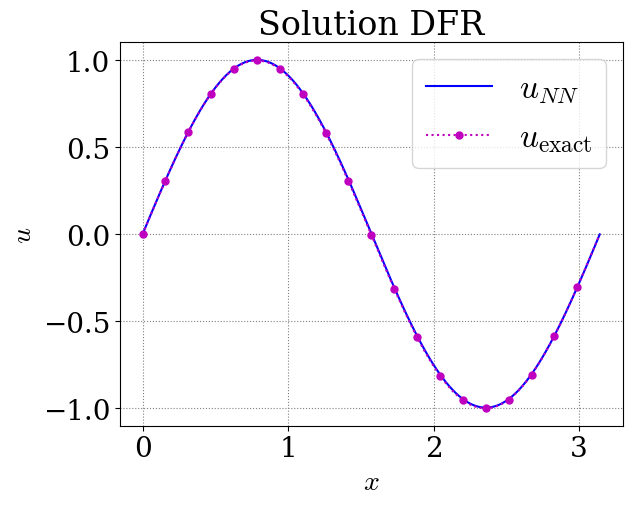

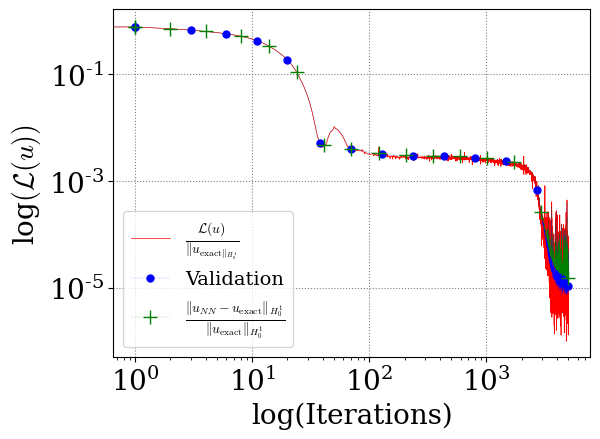

In [ ]:
# =============================================================================
#                         Matplotlib Global Style
# =============================================================================
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

rcParams['font.family']      = 'serif'
rcParams['font.size']        = 20
rcParams['legend.fontsize']  = 22
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.labelsize']   = 20

# =============================================================================
#                      Prepare Spatial Grid for Plotting
# =============================================================================
# Create 1000 evenly spaced points in [0, π] to evaluate the network and exact solution
xlist = tf.experimental.numpy.linspace(0.0, np.pi, num=1000, dtype='float32')

# =============================================================================
#                        Plot PINN Solution vs Exact
# =============================================================================
fig, ax = plt.subplots()

# Plot neural-network prediction u_NN(x)
ax.plot(
    xlist,
    U_model(xlist),
    color='b',
    label=r'$u_{NN}$'
)

# Plot analytical solution u_exact(x) as a dotted magenta line with markers
ax.plot(
    xlist,
    uexact(xlist),
    linestyle='dotted',
    color='m',
    marker='.',
    markersize=10,
    markevery=50,
    label=r'$u_{\mathrm{exact}}$'
)

# Configure grid, labels, title, legend
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.title('Solution DFR')
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.legend(fontsize=24)
plt.tight_layout()

# Save and display the figure
plt.savefig("plot_sol_DFR.pdf", format="pdf", bbox_inches="tight")
plt.show()

# =============================================================================
#                         Plot Training & Validation Loss
# =============================================================================
# Extract loss histories
Loss_rel   = history.history['loss_rel']
val_rel    = history.history['val_value']
error_rel  = history.history['error_value']

fig, ax = plt.subplots()

# Determine marker positions on log-scaled x-axis
num_markers  = 15
log_indices  = np.geomspace(1, len(Loss_rel) - 1, num_markers).astype(int)
num_markers2 = 17
log_indices2 = np.geomspace(1, len(Loss_rel) - 1, num_markers2).astype(int)

# Plot primary loss (red solid)
ax.plot(
    Loss_rel,
    color='r',
    linewidth=0.5,
    label=r"$\frac{\mathcal{L}(u)}{\|u_{\mathrm{exact}}\|_{H_0^1}}$"
)

# Plot validation loss (blue dotted with dot markers)
ax.plot(
    val_rel,
    linestyle='dotted',
    linewidth=0.2,
    color='b',
    marker='.',
    markersize=10,
    markevery=log_indices,
    label='Validation'
)

# Plot H¹₀‐error (green dotted with plus markers)
ax.plot(
    error_rel,
    linestyle='dotted',
    linewidth=0.2,
    color='g',
    marker='+',
    markersize=10,
    markevery=log_indices2,
    label=r"$\frac{\|u_{NN}-u_{\mathrm{exact}}\|_{H_0^1}}{\|u_{\mathrm{exact}}\|_{H_0^1}}$"
)

# Set both axes to logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

# Configure grid, labels, legend, layout
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.xlabel('log(Iterations)')
plt.ylabel(r'log$(\mathcal{L}(u))$')
plt.legend(fontsize=14)
plt.tight_layout()

# Save and display the loss plot
plt.savefig("plot_loss_DFR.pdf", format="pdf", bbox_inches="tight")
plt.show()




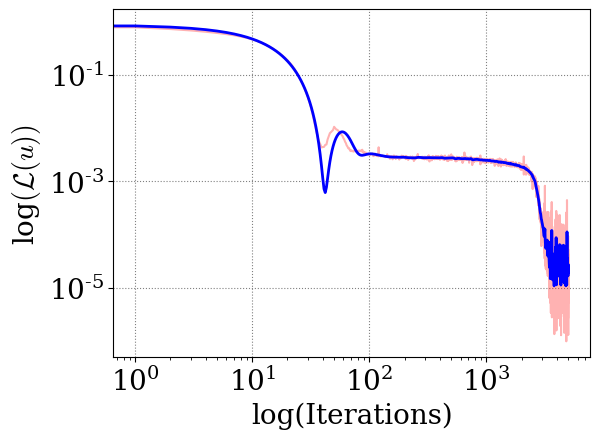

In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import numpy as np  # for any numerical operations if needed

# =============================================================================
#                      Low‑Pass Filter Definition
# =============================================================================
def low_pass_filter(data, cutoff=0.05, order=3):
    """
    Apply a digital low‑pass Butterworth filter to a 1D signal.

    Parameters:
      data   – 1D array of data points (e.g., loss history)
      cutoff – normalized cutoff frequency (0 < cutoff < 1)
      order  – filter order (higher → sharper cutoff)
    Returns:
      Filtered data array of same length as input.
    """
    # Design filter coefficients
    b, a = butter(order, cutoff, btype='low', analog=False)
    # Apply zero‑phase filtering to avoid phase shift
    return filtfilt(b, a, data)

# =============================================================================
#                 Apply Filter to Loss History & Plot
# =============================================================================
# Assume Loss_rel is a 1D array of loss values from training history
# e.g., Loss_rel = history.history['loss']

# Compute filtered loss curve
Loss_filtered = low_pass_filter(Loss_rel)

# Create plot
fig, ax = plt.subplots()

# Plot original loss (faded red for context)
ax.plot(
    Loss_rel,
    color='r',
    alpha=0.3,
    label='Original Loss'
)

# Plot filtered loss (solid blue)
ax.plot(
    Loss_filtered,
    color='b',
    linewidth=2,
    label='Filtered Loss (Low‑pass)'
)

# Use log–log scale to capture decay behavior
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and styling
ax.set_xlabel('log(Iterations)')
ax.set_ylabel(r'log$(\mathcal{L}(u))$')
ax.grid(which='major', linestyle=':', color='gray')
ax.legend()
plt.tight_layout()

# Display the plot
plt.show()
